In [1]:
import argparse
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from chainconsumer import ChainConsumer
from haiku._src.nets.resnet import ResNet18
from jax.lib import xla_bridge
from numpyro import distributions as dist
from numpyro.handlers import condition, seed, trace
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
from sbi_lens.normflow.train_model import TrainModel
from tqdm import tqdm
import numpy as np
import h5py
import healpy as hp 
import jax
import matplotlib.pyplot as plt

print(xla_bridge.get_backend().platform)

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
    
import psutil
# Get CPU memory usage
cpu_memory_usage = psutil.virtual_memory().percent
print("CPU Memory Usage:", cpu_memory_usage, "%")

import GPUtil
# Get available GPUs
gpus = GPUtil.getGPUs()
for gpu in gpus:
    memory_usage_percentage = (gpu.memoryUsed / gpu.memoryTotal) * 100
    print(f"GPU ID: {gpu.id}, GPU Name: {gpu.name}, GPU Memory Usage: {memory_usage_percentage:.2f}%")

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu
CPU Memory Usage: 23.3 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 0.95%


In [2]:
map_kind = 'gaussian' # nbody or nbody_with_baryon_ia or gaussian
loss_name = 'mse'

### Fiducial Model

In [4]:
print("######## CONFIG ########")


sigma_e = 0.26
galaxy_density = gal_per_arcmin2 = 10
field_size = map_size = size = 10
field_npix = N = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6
nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area

# Create our fiducial observations
pix_area = (map_size * 60 / N) ** 2  # arcmin2
map_size_rad = map_size / 180 * jnp.pi  # radians



print("######## OBSERVED DATA ########")
filename = '/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5'
f = h5py.File(filename, "r")
dataset_grid = f['parameters']['fiducial']
cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0']/100,
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T
truth = list(cosmo_parameters[0])
path = '/gpfsdswork/dataset/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_baryonified512.h5'
m_data = h5py.File(path, "r")
m_data = np.array(m_data['kg']['stage3_lensing{}'.format(4)]) + np.array(m_data['ia']['stage3_lensing{}'.format(4)])
proj = hp.projector.GnomonicProj(rot=[0, 0, 0], xsize=xsize, ysize=xsize, reso=reso)
m_data = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))

m_data = dist.Independent(
            dist.Normal(
                m_data, 
                sigma_e / jnp.sqrt((galaxy_density * (field_size * 60 / field_npix) ** 2))
            ),
            2
        ).sample(jax.random.PRNGKey(0),(1,))

######## CONFIG ########
######## OBSERVED DATA ########


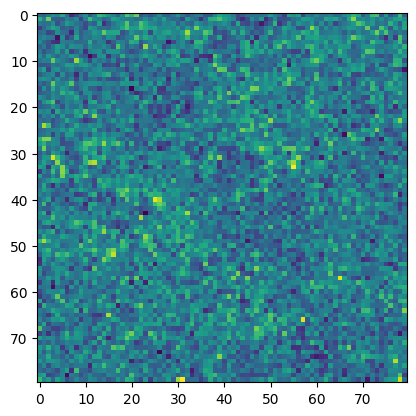

In [5]:
plt.imshow(m_data.squeeze())

### Compressing Data

In [6]:
print("######## CREATE COMPRESSOR ########")

# compressor
class CompressorCNN2D(hk.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim

    def __call__(self, x):
        net_x = hk.Conv2D(32, 3, 2)(x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(64, 3, 2)(net_x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(128, 3, 2)(net_x)
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.AvgPool(16,8,'SAME')(net_x) 
        net_x = hk.Flatten()(net_x)

        net_x = hk.Linear(64)(net_x)
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Linear(self.output_dim)(net_x)
        
        return net_x.squeeze()
    
compressor = hk.transform_with_state(lambda y: CompressorCNN2D(dim)(y))

######## CREATE COMPRESSOR ########


In [8]:
path = f"./save_params/{loss_name}/{map_kind}/params_nd_compressor_batch100000.pkl"
with open(path, "rb") as g:
    parameters_compressor = pickle.load(g)
    
path = f"./save_params/{loss_name}/{map_kind}/opt_state_resnet_batch100000.pkl"
with open(path, "rb") as g:
    opt_state_resnet = pickle.load(g)

In [9]:
print("######## DATA AUGMENTATION ########")
tf.random.set_seed(1)

if map_kind =='nbody_with_baryon_ia':
    print('nbody w baryon and ia')
    def augmentation_noise(
        example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
    ):
        x = example["map_nbody_w_baryon_ia"]
        x += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"maps": x, "theta": example["theta"]}

elif map_kind =='nbody':
    print('nbody')
    def augmentation_noise(
        example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
    ):
        x = example["map_nbody"]
        x += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"maps": x, "theta": example["theta"]}
    
elif map_kind=='gaussian':
    print('gaussian')
    def augmentation_noise(
        example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
    ):
        x = example["map_gaussian"]
        x += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"maps": x, "theta": example["theta"]}
    

def augmentation_flip(example):
    x = tf.expand_dims(example["maps"], -1)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return {"maps": x, "theta": example["theta"]}

def rescale_h(example): 
    x = example['theta']
    index_to_update = 3
    x = tf.tensor_scatter_nd_update(x, [[index_to_update]], [x[index_to_update] / 100])
    return {"maps": example["maps"], "theta": x}

def augmentation(example):
    return rescale_h(
        augmentation_flip(
            augmentation_noise(
                example=example,
                sigma_e=sigma_e,
                galaxy_density=galaxy_density,
                field_size=field_size,
                field_npix=field_npix,
            )
        )
    )


######## DATA AUGMENTATION ########
gaussian


In [10]:
print("######## LEARNED TRANSFO ########")
import pickle
import os

total_steps = 50_000
lr_rate = 1e-2
batch = 49999
           
PATH_experiment_vae = f"{total_steps}_{lr_rate}_new49"

with open(f"./save_params/{PATH_experiment_vae}/params_nd_vae_batch{batch}.pkl", "rb") as fp:
    vae_params = pickle.load(fp)

with open(f"./save_params/{PATH_experiment_vae}/opt_state_vae_batch{batch}.pkl", "rb") as fp:
    opt_state_vae = pickle.load(fp)

with open(f"./save_params/{PATH_experiment_vae}/state_vae_batch{batch}.pkl", "rb") as fp:
    state_vae = pickle.load(fp)

from unet_model import UResNet
from collections.abc import Mapping
import haiku as hk

class ConvDecoder(hk.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        
    def __call__(self, x):
        residual = hk.Conv2D(1, 3, 1)(x)
        residual = jax.nn.leaky_relu(residual)
        residual = hk.Conv2D(1, 3, 1)(residual) 
        residual = jax.nn.leaky_relu(residual)
        residual = hk.Conv2D(1, 3, 1)(residual)
        return (residual + x).squeeze()


decoder_eval = hk.without_apply_rng(
    hk.transform_with_state(
        lambda z: ConvDecoder(output_dim=1)(
            z.reshape([-1, N, N, 1])
        )
    )
)

@jax.jit
@jax.vmap
def learned_transfo(gaussian_map, key): 
    out_vae, _ =  decoder_eval.apply(vae_params, state_vae[1], gaussian_map.reshape([1, N, N, 1]))
    posterior_x = dist.Independent(
        dist.Normal(
            out_vae.squeeze(),
            sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        ),
        2,
    )
    
    return posterior_x.sample(key)



######## LEARNED TRANSFO ########


In [11]:
import tensorflow_datasets as tfds
import numpy
print("######## COMPRESS DATA ########")
ds = tfds.load(
    'CosmogridGridDataset/grid',
    split='test'
)
ds = ds.map(augmentation)
ds = ds.batch(500)

iter = ds.as_numpy_iterator()

y = []
theta = []
score = []

masterkey = jax.random.PRNGKey(789)

for example in iter:
  key, master = jax.random.split(masterkey,2)
  nbody_maps = learned_transfo(example['maps'],jax.random.split(key,len(example['maps'])))
  nbody_maps = nbody_maps.reshape([-1,N,N,1])
  comp_y,_ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      nbody_maps
    )
  y.append(comp_y)
  theta.append(example['theta'])

dataset = {
    'theta': np.concatenate(theta, axis=0), 
    'x': np.concatenate(y, axis=0), 
}
compressed_dataset_test, _ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      example['maps']
    )
theta_test =example['theta']

####################################
ds = tfds.load(
    'CosmogridGridDataset/grid',
    split='train'
)
ds = ds.map(augmentation)
ds = ds.batch(500)

iter = ds.as_numpy_iterator()

y = []
theta = []
score = []

masterkey = jax.random.PRNGKey(89)


for example in iter:
  key, master = jax.random.split(masterkey,2)
  nbody_maps = learned_transfo(example['maps'],jax.random.split(key,len(example['maps'])))
  nbody_maps = nbody_maps.reshape([-1,N,N,1])
  comp_y,_ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      nbody_maps
    )
  y.append(comp_y)
  theta.append(example['theta'])

dataset_test = {
    'theta': np.concatenate(theta, axis=0), 
    'x': np.concatenate(y, axis=0), 
}

compressed_dataset_train, _ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      example['maps']
    )
theta_train =example['theta']

###########################################
compressed_m_data, _ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      m_data.reshape([1,field_npix,field_npix,nbins])
    )

######## COMPRESS DATA ########


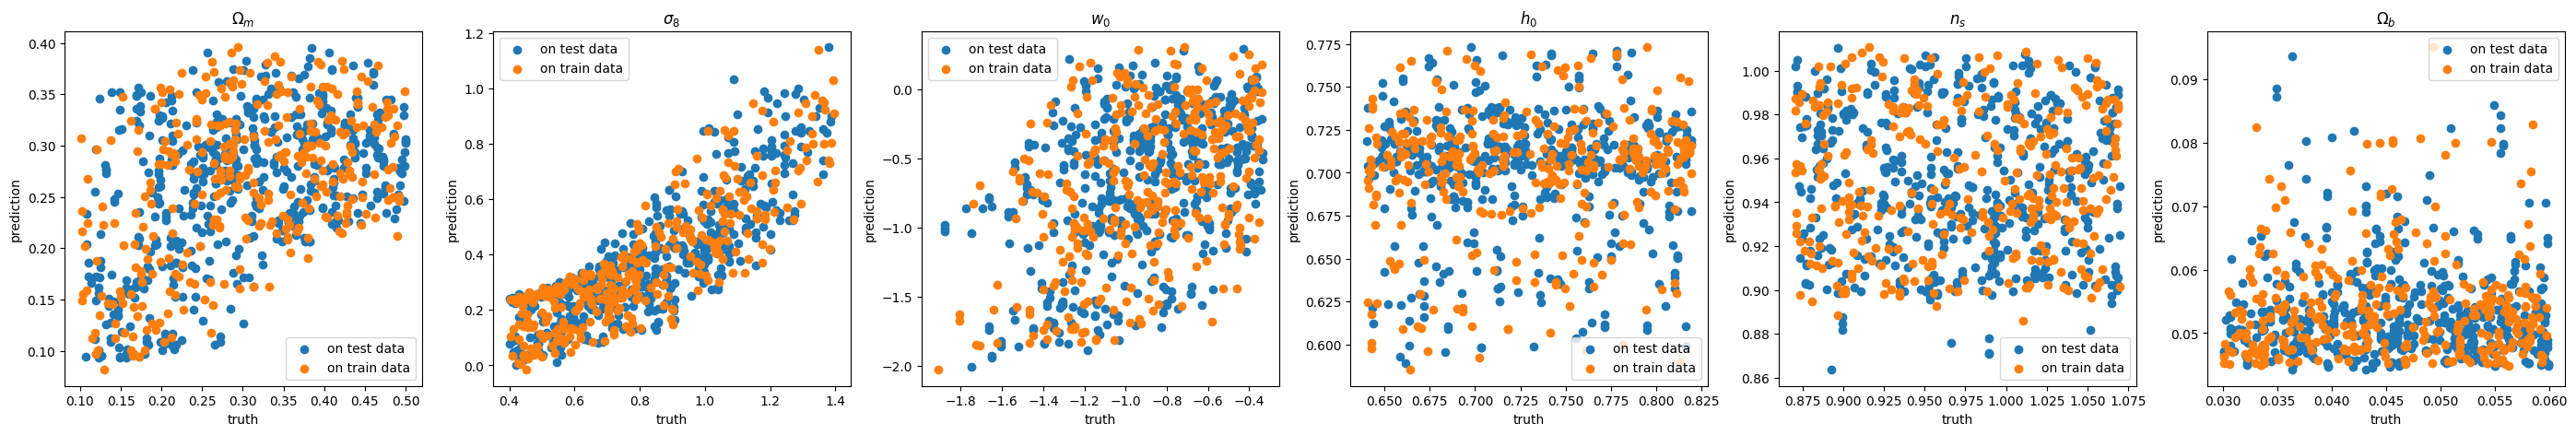

In [12]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
plt.figure(figsize=(35,5))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.scatter(theta_test[:,i], compressed_dataset_test[:,i], label = 'on test data')
    plt.scatter(theta_train[:,i], compressed_dataset_train[:,i], label = 'on train data')
    plt.xlabel('truth')
    plt.ylabel('prediction')
    plt.title(params_name[i])
    plt.legend()

### Inference

In [16]:
print("######## CREATE NDE ########")
# Create neural density estimator (NDE) to approximate p(theta | y)

summary_stat_dim = 6
nb_params_to_infer = 6
batch_size = 128


# Affine bijection used in the RealNVP coupling
bijector_ff = partial(
  AffineCoupling,
  layers=[128] * 4,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_ff = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_ff
)



class NF(hk.Module):
    def __call__(self, y):
        nvp = NF_ff(nb_params_to_infer)(y)
        return nvp

# log probability of the NDE
nf_logp_ff = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF()(theta).log_prob(y).squeeze()
    )
)

######## CREATE NDE ########


In [17]:
print("######## UTILS FUN ########")

# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nf_logp_ff.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

######## UTILS FUN ########


######## TRAINING ########


loss -21.791: 100%|██████████| 100000/100000 [04:09<00:00, 400.43it/s]


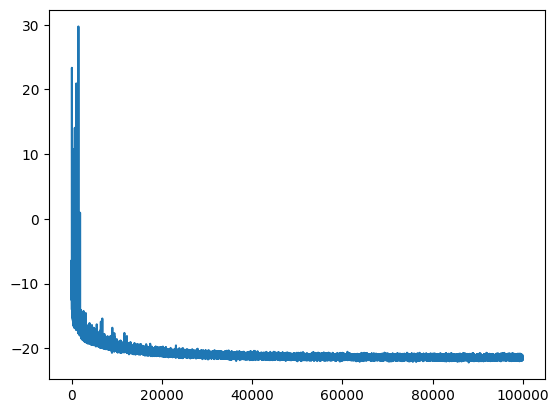

In [18]:
print("######## TRAINING ########")
# init nf params
params_ff = nf_logp_ff.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.zeros([1, 6]),
    0.5 * jnp.zeros([1, 6])
)

total_steps = 100_000
nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=1e-3,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-6,
)

# define optimizer
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_ff = optimizer.init(params_ff)


# training
from tqdm import tqdm

batch_size = 128
batch_loss = []
loss_train = []
loss_test=[]
pbar = tqdm(range(total_steps))

for batch in pbar:
    inds = np.random.randint(0, len(dataset['theta']), batch_size)

    l, params_ff, opt_state_ff = update(
      params_ff,
      opt_state_ff,
      dataset['theta'][inds],
      dataset['x'][inds],
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")
    
    
    if batch % 1_000 == 0:

        # save params
        with open(f"./save_params/{loss_name}/gaussian/params_nd_flow_batch{batch}.pkl", "wb") as fp:
            pickle.dump(params_ff, fp)


        inds2 = np.random.randint(0, len(dataset_test["theta"]), batch_size)
        b_loss_test, _, _ = update(
          params_ff,
          opt_state_ff,
          dataset_test["theta"][inds2],
          dataset_test['x'][inds2],
        )
        

        loss_train.append(l)
        loss_test.append(b_loss_test)


plt.plot(batch_loss[100:])

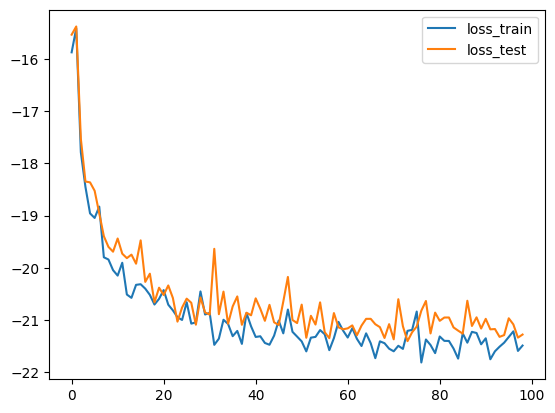

In [19]:
plt.plot(loss_train[1:], label ='loss_train')
plt.plot(loss_test[1:], label = 'loss_test')
plt.legend()

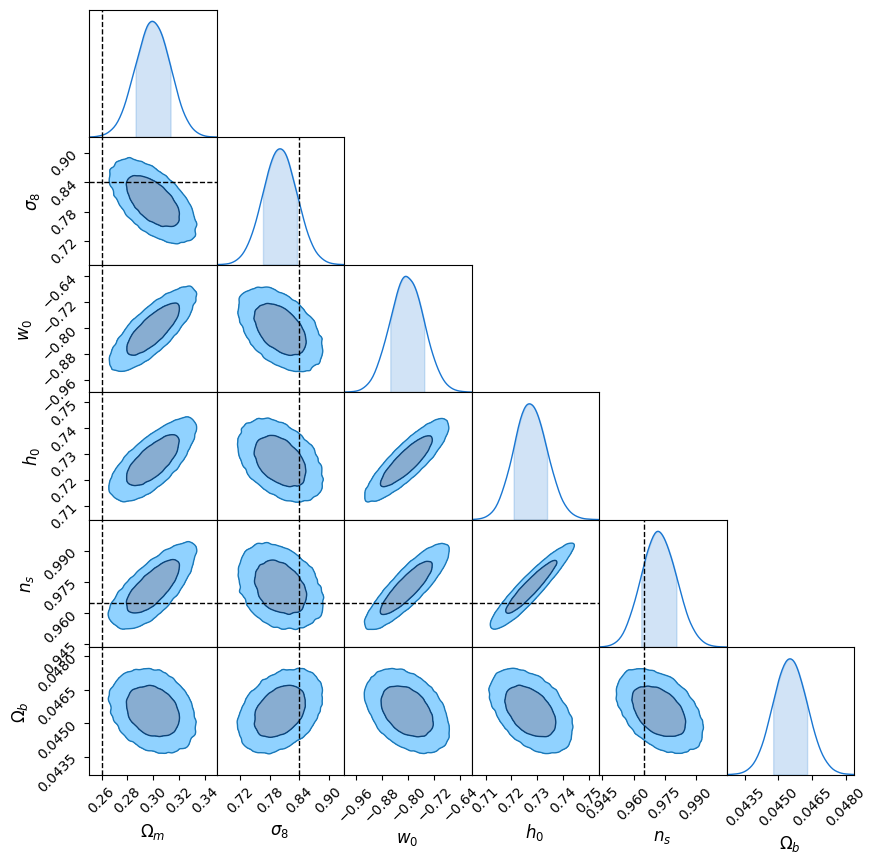

In [20]:
# just checking the learned likelihood

nvp_sample_nd = hk.transform(
  lambda y : NF()(y).sample(100000, seed=hk.next_rng_key())
)

# plot infered params
sample_nd = nvp_sample_nd.apply(
      params_ff,
      rng = jax.random.PRNGKey(43),
      y = jnp.array(truth) * jnp.ones([100_000, 6])
)


from chainconsumer import ChainConsumer

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
c = ChainConsumer()

c.add_chain(
    sample_nd,
    shade_alpha = 0.5, 
    parameters = params_name, 
    name = f'sbi with {map_kind} maps'
)

fig = c.plotter.plot(figsize=1.,truth=truth)

In [21]:
print("######## DEFINING FUN FOR MCMC ########") 
# define prior 
def log_prob_prior(theta):
    Om_logprob = tfd.Uniform(0.1,0.5).log_prob(theta[0])
    s8_logprob = tfd.Uniform(0.4,1.4).log_prob(theta[1])
    h_logprob = tfd.Uniform(0.64, 0.82).log_prob(theta[3])
    Ob_logprob = tfd.Uniform(0.03,0.06).log_prob(theta[5])
    ns_logprob = tfd.Uniform(0.87, 1.07).log_prob(theta[4])
    w0_logprob = tfd.Uniform(-2.0, -0.333).log_prob(theta[2])
    return Om_logprob + s8_logprob + h_logprob + Ob_logprob + ns_logprob + w0_logprob
                                        

def log_prob_fn(params, theta, y):
        return nf_logp_ff.apply(params, theta, y)
    
@jax.vmap
def unnormalized_log_prob(theta):
    prior = log_prob_prior(theta)

    likelihood = log_prob_fn(
        params_ff,
        theta.reshape([1, 6]),
        jnp.array(compressed_m_data).reshape([1, 6]),
    )

    return likelihood + prior

######## DEFINING FUN FOR MCMC ########


In [22]:
print("######## RUN MCMC ########") 
num_results = 200_000
num_burnin_steps = 400
num_chains = 10
key = jax.random.PRNGKey(0)

# Initialize the HMC transition kernel.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1e-2,
    ),
    num_adaptation_steps=int(num_burnin_steps * 0.8),
)

# Run the chain (with burn-in).
# @jax.jit
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=jnp.array(truth) * jnp.ones([num_chains, 6]),
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
        seed=key,
    )

    return samples, is_accepted

samples_hmc, is_accepted_hmc = run_chain()
sample_nd = samples_hmc[is_accepted_hmc]

######## RUN MCMC ########


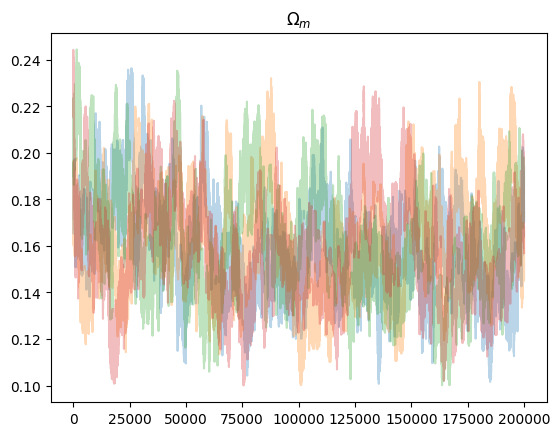

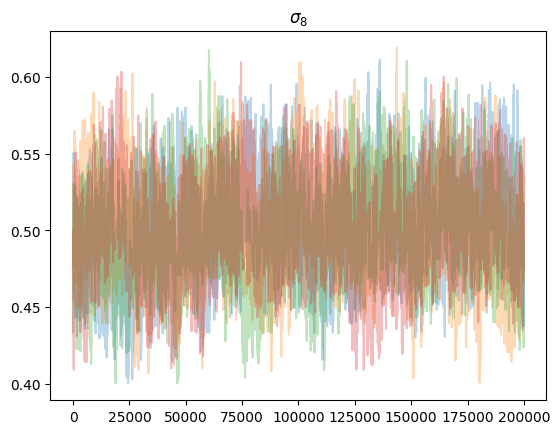

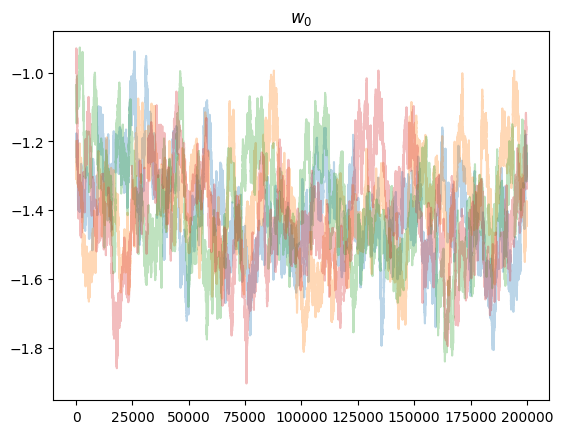

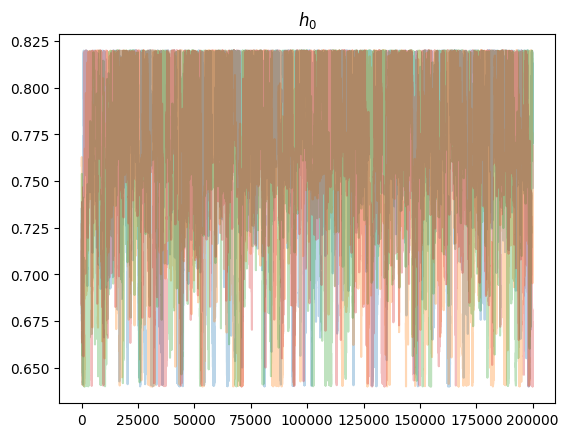

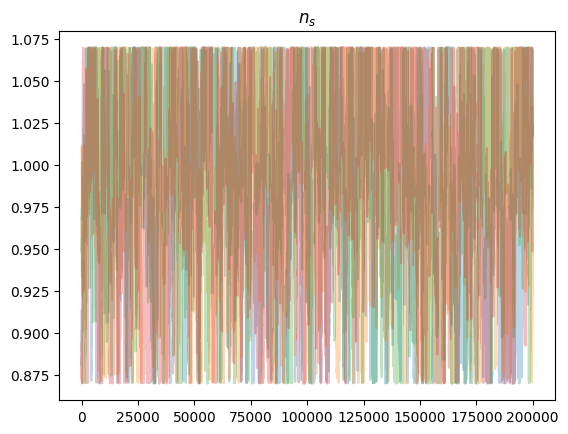

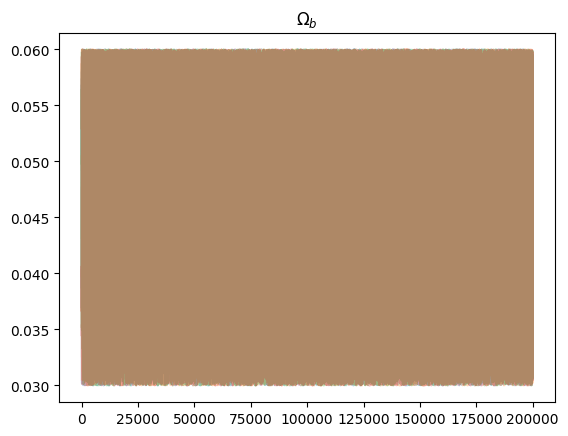

In [23]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
for i in range(6):
    for j in range(4):
        plt.plot(samples_hmc[:,j, i], alpha=0.3)
        plt.title(params_name[i])
    plt.show()

In [24]:
Om_sample = tfd.Uniform(0.1,0.5).sample(1000, jax.random.PRNGKey(0))
s8_sample  = tfd.Uniform(0.4,1.4).sample(1000, jax.random.PRNGKey(10))
h_sample = tfd.Uniform(0.64, 0.82).sample(1000, jax.random.PRNGKey(20))
Ob_sample  = tfd.Uniform(0.03,0.06).sample(1000, jax.random.PRNGKey(30))
ns_sample  = tfd.Uniform(0.87, 1.07).sample(1000, jax.random.PRNGKey(40))
w0_sample  = tfd.Uniform(-2.0, -0.333).sample(1000, jax.random.PRNGKey(50))

prior = jnp.array([Om_sample, s8_sample, w0_sample, h_sample, ns_sample, Ob_sample]).T

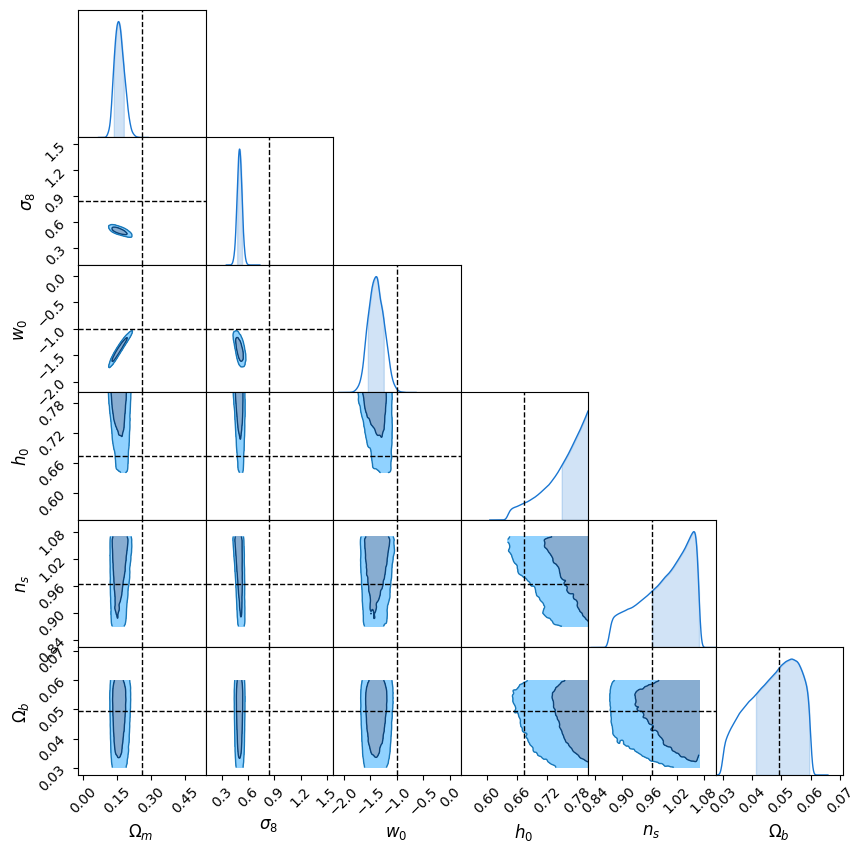

In [25]:
from chainconsumer import ChainConsumer

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
c = ChainConsumer()

c.add_chain(
    sample_nd,
    shade_alpha = 0.5, 
    parameters = params_name, 
    name = f'sbi with {map_kind} maps'
)

fig = c.plotter.plot(figsize=1.,truth=truth , extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)


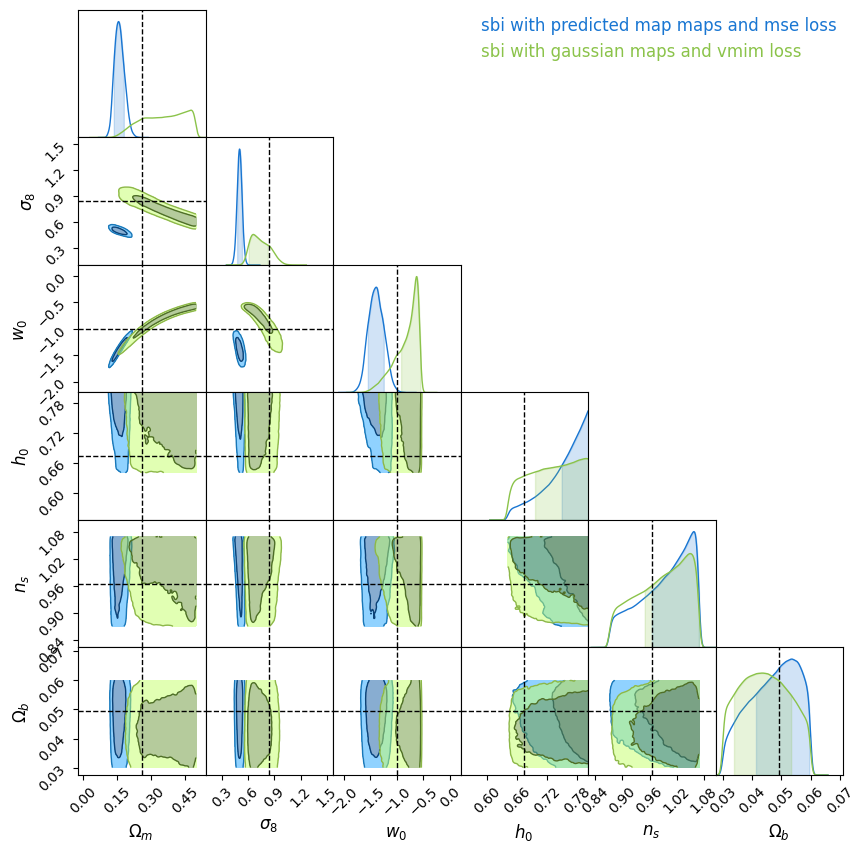

In [28]:

posterior_vmim_gaussian = jnp.load('/gpfsdswork/projects/rech/eqw/ufa23yn/dev/PoCLikelihoodInference/sbi/nde_notebooks/posterior_vmim_gaussian.npy')
posterior_vmim_nbody_with_baryon_ia = jnp.load('/gpfsdswork/projects/rech/eqw/ufa23yn/dev/PoCLikelihoodInference/sbi/nde_notebooks/posterior_vmim_nbody_with_baryon_ia.npy')

from chainconsumer import ChainConsumer

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
c = ChainConsumer()

c.add_chain(
    sample_nd,
    shade_alpha = 0.5, 
    parameters = params_name, 
    name = f'sbi with predicted map maps and {loss_name} loss'
)

c.add_chain(
    posterior_vmim_nbody_with_baryon_ia,
    shade_alpha = 0.5,
    parameters = params_name,
    name = f'sbi with {map_kind} maps and vmim loss'
)


fig = c.plotter.plot(figsize=1.,truth=truth , extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)

In [ ]:
jnp.save(f'posterior_{loss_name}_{map_kind}', sample_nd)

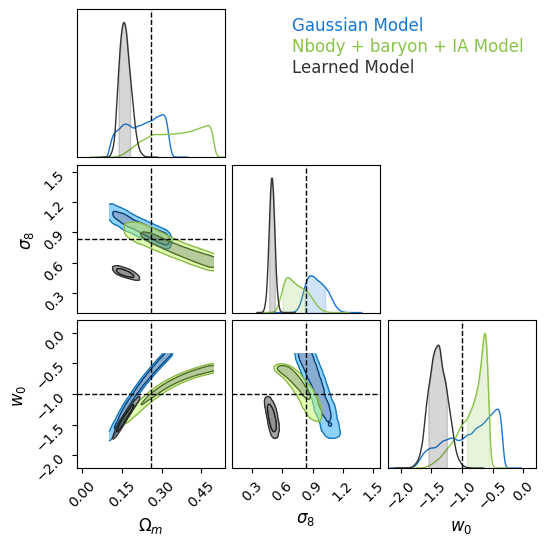

In [29]:

c = ChainConsumer()


c.add_chain(
    posterior_vmim_gaussian[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3],
    name = 'Gaussian Model',
)

c.add_chain(
    posterior_vmim_nbody_with_baryon_ia[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3], 
    name = 'Nbody + baryon + IA Model '
)

c.add_chain(
    sample_nd[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3],
    name = 'Learned Model', 
    kde = 1,
    color='black'
)

fig = c.plotter.plot(
    figsize=1.2,
    truth=truth[:3],
    extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)